In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

import pandas as pd
import numpy as np
import re
import json
import importlib

import matplotlib.pyplot as plt
import seaborn as sns

import pingouin as pg
import scikit_posthocs as sp

from scipy import stats
from scipy.stats import ttest_ind, mannwhitneyu, f_oneway, kruskal, chi2_contingency, fisher_exact
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

In [2]:
def print_title(title, line_length = 60, symbol = '-'):
    separator = symbol * ((line_length - len(title) - 2) // 2)
    print(f"{separator} {title} {separator}")

# EXPERIMENT DESIGN

## SOURCES INGESTION

-----------------------------------------------------------------------------------------

# EXPERIMENT RESULTS

## SOURCES INGESTION

### LOAD

In [3]:
# Load raw data
file_name = 'ab_test_example_3.csv'
df_raw = pd.read_csv('../data/' + file_name)
display(df_raw.head(5))

# Make a copy
df = df_raw.copy()

# Check dtypes
print_title('INITIAL DATA TYPES')
print(df.dtypes)

,U_ID,VARIANT,USER_SEGMENT,PROMO_TAG,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT
0,203,CONTROL,MONTHLY_ACTIVE,sms_enrolment,NaN,0,2023-06-02 15:33:01,0,99,0,NaN
1,1577,CONTROL,MONTHLY_ACTIVE,sms_enrolment,NaN,0,2023-06-02 15:32:44,0,99,0,NaN
2,3326,CONTROL,MONTHLY_ACTIVE,sms_enrolment,NaN,0,2023-06-02 15:32:22,0,99,0,NaN
3,6004,CONTROL,MONTHLY_ACTIVE,sms_enrolment,NaN,0,2023-06-02 15:31:51,0,99,0,NaN
4,8643,CONTROL,MONTHLY_ACTIVE,sms_enrolment,NaN,0,2023-06-02 15:31:20,0,99,0,NaN


-------------------- INITIAL DATA TYPES --------------------
U_ID                              int64
VARIANT                          object
USER_SEGMENT                     object
PROMO_TAG                        object
PROMOTER_U_ID                   float64
IS_TREATMENT                      int64
WHEN_ENTERED_INTO_EXPERIMENT     object
COUNT_TRANSFERS                   int64
DAYS_TRANSACTING                  int64
DISTINCT_RECEIVERS                int64
TOTAL_TRANSFER_AMOUNT           float64
dtype: object


### DTYPES

In [4]:
def format_columns(df, datetime_columns=[], int64_columns=[], float64_columns=[], str_columns=[]):
    for col in datetime_columns:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    for col in int64_columns:
        if col in df.columns:
            df[col] = df[col].astype('Int64')  

    for col in float64_columns:
        if col in df.columns:
            df[col] = df[col].astype('float64')

    for col in str_columns:
        if col in df.columns:
            df[col] = df[col].astype('str')
    
    return df

In [5]:
datetime_columns = ['WHEN_ENTERED_INTO_EXPERIMENT']
int64_columns = ['U_ID', 'PROMOTER_U_ID', 'IS_TREATMENT', 'COUNT_TRANSFERS', 'DAYS_TRANSACTING', 'DISTINCT_RECEIVERS']
float64_columns = ['TOTAL_TRANSFER_AMOUNT']
str_columns = ['VARIANT', 'USER_SEGMENT', 'PROMO_TAG']

# Basic data conversion
df = format_columns(df, datetime_columns, int64_columns, float64_columns, str_columns)

# Check dtypes
print_title('CONVERTED DATA TYPES')
print(df.dtypes)
display(df.head(5))

------------------- CONVERTED DATA TYPES -------------------
U_ID                                     Int64
VARIANT                                 object
USER_SEGMENT                            object
PROMO_TAG                               object
PROMOTER_U_ID                            Int64
IS_TREATMENT                             Int64
WHEN_ENTERED_INTO_EXPERIMENT    datetime64[ns]
COUNT_TRANSFERS                          Int64
DAYS_TRANSACTING                         Int64
DISTINCT_RECEIVERS                       Int64
TOTAL_TRANSFER_AMOUNT                  float64
dtype: object


,U_ID,VARIANT,USER_SEGMENT,PROMO_TAG,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT
0,203,CONTROL,MONTHLY_ACTIVE,sms_enrolment,<NA>,0,2023-06-02 15:33:01,0,99,0,NaN
1,1577,CONTROL,MONTHLY_ACTIVE,sms_enrolment,<NA>,0,2023-06-02 15:32:44,0,99,0,NaN
2,3326,CONTROL,MONTHLY_ACTIVE,sms_enrolment,<NA>,0,2023-06-02 15:32:22,0,99,0,NaN
3,6004,CONTROL,MONTHLY_ACTIVE,sms_enrolment,<NA>,0,2023-06-02 15:31:51,0,99,0,NaN
4,8643,CONTROL,MONTHLY_ACTIVE,sms_enrolment,<NA>,0,2023-06-02 15:31:20,0,99,0,NaN


## DATA CLEANING

### CHECKS

In [6]:
variant_column = 'VARIANT'

In [7]:
# Quick checks on data
print_title('DF INFO')
display(df.info())

print_title('DF DESCRIBE')
display(df.describe())

# Check distribution of variants
print_title('VARIANT DISTRIBUTION')
display(df[variant_column].value_counts())

------------------------- DF INFO -------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45623 entries, 0 to 45622
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   U_ID                          45623 non-null  Int64         
 1   VARIANT                       45623 non-null  object        
 2   USER_SEGMENT                  45623 non-null  object        
 3   PROMO_TAG                     45623 non-null  object        
 4   PROMOTER_U_ID                 29347 non-null  Int64         
 5   IS_TREATMENT                  45623 non-null  Int64         
 6   WHEN_ENTERED_INTO_EXPERIMENT  45623 non-null  datetime64[ns]
 7   COUNT_TRANSFERS               45623 non-null  Int64         
 8   DAYS_TRANSACTING              45623 non-null  Int64         
 9   DISTINCT_RECEIVERS            45623 non-null  Int64         
 10  TOTAL_TRANSFER_AMOUNT         1887

None

----------------------- DF DESCRIBE -----------------------


,U_ID,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT
count,45623.0,29347.0,45623.0,45623,45623.0,45623.0,45623.0,1.887700e+04
mean,22811.996164,21661038.772549,0.354426,2023-05-23 04:48:41.669684224,1.013677,0.879995,0.817548,5.374970e+04
min,1.0,655650.0,0.0,2023-04-18 00:56:14,0.0,0.0,0.0,5.000000e+00
25%,11406.5,8451570.0,0.0,2023-05-13 13:35:21.500000,0.0,0.0,0.0,2.000000e+03
50%,22812.0,18808489.0,0.0,2023-05-25 17:15:51,0.0,0.0,0.0,5.050000e+03
75%,34217.5,36522003.0,1.0,2023-06-01 15:37:50,1.0,1.0,1.0,2.938000e+04
max,45616.0,40557197.0,1.0,2023-06-29 18:37:31,241.0,99.0,219.0,1.201984e+07
std,13170.363363,13873536.242459,0.478344,NaN,2.910549,2.54671,2.138211,3.060536e+05


------------------- VARIANT DISTRIBUTION -------------------


VARIANT
CONTROL        29453
PRICE_PROMO    16170
Name: count, dtype: int64

### DUPLICATES

In [8]:
# Check for and drop duplicates in the entire DataFrame
duplicated_rows = df.duplicated().sum()
print('# of duplicated rows: ', duplicated_rows)

if duplicated_rows > 0:
    df = df.drop_duplicates()
    print('Duplicates in the DataFrame removed.')
else:
    print('No duplicates in the DataFrame found.')

# of duplicated rows:  0
No duplicates in the DataFrame found.


In [9]:
primary_key_column = 'U_ID'
timestamp_column = ''

# Check for duplicates in the unique columns
duplicated_rows = df[df[primary_key_column].duplicated(keep=False)]
print(f'# of duplicated on {primary_key_column} column: {duplicated_rows[primary_key_column].nunique()}')

if not duplicated_rows.empty:
    print(f'Duplicated {primary_key_column} and their rows:')
    display(duplicated_rows.sort_values(by = 'U_ID'))

    # Keep only the first following timestamp column order
    if timestamp_column == '':
        df = df.drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated U_ID.')
    else:
        df = df.sort_values(timestamp_column).drop_duplicates(subset=primary_key_column, keep='last')
        print('Kept the most recent row for each duplicated U_ID.')

# of duplicated on U_ID column: 7
Duplicated U_ID and their rows:


,U_ID,VARIANT,USER_SEGMENT,PROMO_TAG,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT
45599,45592,PRICE_PROMO,CHURNED,nan,8962332,1,2023-05-09 18:47:20,0,0,0,NaN
45616,45592,PRICE_PROMO,CHURNED,nan,11369216,1,2023-05-22 18:32:41,0,0,0,NaN
45600,45593,CONTROL,CHURNED,nan,26351398,0,2023-04-28 10:55:06,0,0,0,NaN
45617,45593,PRICE_PROMO,CHURNED,nan,11369216,1,2023-04-18 00:56:14,0,0,0,NaN
18887,45594,PRICE_PROMO,CHURNED,nan,38443462,1,2023-05-20 13:26:49,1,1,1,2500.0
45618,45594,PRICE_PROMO,CHURNED,nan,11369216,1,2023-04-18 00:56:14,0,0,0,NaN
45601,45595,PRICE_PROMO,CHURNED,nan,2903573,1,2023-05-10 16:58:04,0,0,0,NaN
45619,45595,PRICE_PROMO,CHURNED,nan,11369216,1,2023-04-18 00:56:14,0,0,0,NaN
18888,45596,CONTROL,CHURNED,nan,29387022,0,2023-05-15 11:13:23,1,1,1,1010.0
45620,45596,PRICE_PROMO,CHURNED,nan,11369216,1,2023-04-18 00:56:14,0,0,0,NaN


Kept the most recent row for each duplicated U_ID.


### NULLS

In [10]:
# Check for missing values
missing_values = df.isnull().sum()
print_title('NUMBER OF NULL VALUES')
print(missing_values)

------------------ NUMBER OF NULL VALUES ------------------
U_ID                                0
VARIANT                             0
USER_SEGMENT                        0
PROMO_TAG                           0
PROMOTER_U_ID                   16276
IS_TREATMENT                        0
WHEN_ENTERED_INTO_EXPERIMENT        0
COUNT_TRANSFERS                     0
DAYS_TRANSACTING                    0
DISTINCT_RECEIVERS                  0
TOTAL_TRANSFER_AMOUNT           26743
dtype: int64


In [11]:
# Fill null columns
df['TOTAL_TRANSFER_AMOUNT'] = df['TOTAL_TRANSFER_AMOUNT'].fillna(0)

### INCONSISTENCIES

In [12]:
# Checks errors in variant labeling
checks = df[(df['IS_TREATMENT'] == 1) & (df['VARIANT'] != 'PRICE_PROMO')]
display(checks)
checks = df[(df['IS_TREATMENT'] == 0) & (df['VARIANT'] != 'CONTROL')]
display(checks)

,U_ID,VARIANT,USER_SEGMENT,PROMO_TAG,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT


,U_ID,VARIANT,USER_SEGMENT,PROMO_TAG,PROMOTER_U_ID,IS_TREATMENT,WHEN_ENTERED_INTO_EXPERIMENT,COUNT_TRANSFERS,DAYS_TRANSACTING,DISTINCT_RECEIVERS,TOTAL_TRANSFER_AMOUNT


## METRICS DEFINITION

In [13]:
# calculate the metrics, use metric_cnt_ or metric_cvr_
df['metric_cnt_total_transfer_amount'] = df['TOTAL_TRANSFER_AMOUNT']
df['metric_cvr_transaction'] = df['TOTAL_TRANSFER_AMOUNT'].apply(lambda x: 1 if x > 0 else 0, 1)

/var/folders/hv/ckh3m6gn1sd45q2qctrqcwzh0000gn/T/ipykernel_28304/2439425549.py:3: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  df['metric_cvr_transaction'] = df['TOTAL_TRANSFER_AMOUNT'].apply(lambda x: 1 if x > 0 else 0, 1)


## DATA ANALYSIS

In [14]:
def remove_outliers(df, metric_column, factor=1.5, threshold=0.1):
    q1 = df[metric_column].quantile(0.2)
    q3 = df[metric_column].quantile(0.8)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr

    print("Low outlier limit:", lower_bound)
    print("Upper outlier limit:", upper_bound)

    initial_count = df.shape[0]
    df_filtered = df.loc[(df[metric_column] >= lower_bound) & (df[metric_column] <= upper_bound)]
    final_count = df_filtered.shape[0]
    removed_percentage = (initial_count - final_count) / initial_count

    print(f"Filtered {initial_count - final_count} rows ({removed_percentage:.2%}) from {initial_count} to {final_count}")

    is_strong_outlier_effect = removed_percentage > threshold
    print(f"is_strong_outlier_effect: {is_strong_outlier_effect}")

    return df_filtered, is_strong_outlier_effect

In [50]:
# Select metrics and columns involved in the test
primary_key_column = 'U_ID'
metric_column = 'metric_cnt_total_transfer_amount'
variant_column = 'VARIANT'

columns_selection_df = df[[primary_key_column, variant_column, metric_column]]
metric_type = (
    'continuous' if metric_column.startswith('metric_cnt_') else
    'proportion' if metric_column.startswith('metric_cvr_') else
    None
)
outliers_filtered_df, is_strong_outlier_effect = remove_outliers(columns_selection_df, metric_column, 1)

# Filter outliers:
filter_outliers = False

if filter_outliers:
    selected_df = outliers_filtered_df.copy()
else:
    selected_df = columns_selection_df.copy()

display(selected_df.sample(5))

Low outlier limit: -5650.0
Upper outlier limit: 11300.0
Filtered 7183 rows (15.75%) from 45616 to 38433
is_strong_outlier_effect: True


,U_ID,VARIANT,metric_cnt_total_transfer_amount
8991,9646,PRICE_PROMO,10000.0
26306,15641,CONTROL,0.0
22521,6840,CONTROL,0.0
19346,851,CONTROL,0.0
5914,14624,CONTROL,8585.0


### NUMBER OF VARIANTS

In [51]:
# Test multiple variants
if False:
    np.random.seed(42)
    num_rows = len(df)
    num_to_change = num_rows // 3
    indices_to_change = np.random.choice(df.index, size=num_to_change, replace=False)
    selected_df.loc[indices_to_change, "VARIANT"] = "TEST_VARIANT"

In [52]:
num_variants = selected_df[variant_column].nunique()

print(f"Number of Variants: {num_variants}")
print(f"Variants: {selected_df[variant_column].unique()}")

Number of Variants: 2
Variants: ['CONTROL' 'PRICE_PROMO']


### SAMPLE SIZES

In [53]:
# check if the sample size is large enough
# check if the variant sizes ar equal or not and the proportion

sample_sizes = selected_df[variant_column].value_counts()
print("Sample sizes per variant:")
print(sample_sizes)

variant_proportion = sample_sizes / sample_sizes.sum()
print("\nProportion per variant:")
print(variant_proportion)

variant_ratio = sample_sizes.max() / sample_sizes.min()
print(f"\nVariant Ratio (N = max/min): {variant_ratio:.2f}")

Sample sizes per variant:
VARIANT
CONTROL        29450
PRICE_PROMO    16166
Name: count, dtype: int64

Proportion per variant:
VARIANT
CONTROL        0.645607
PRICE_PROMO    0.354393
Name: count, dtype: float64

Variant Ratio (N = max/min): 1.82


### SAMPLE DISTRIBUTION

In [54]:
sns.set_style("white")

def remove_axes_frame(ax):
    for spine in ax.spines.values():
        spine.set_visible(False)

def calculate_distribution(selected_df, variant_column, metric_column):
    results = {}
    variants = selected_df[variant_column].unique()
    for variant in variants:
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        if len(metric_data) < 5000:
            stat, p_value = stats.shapiro(metric_data)
            test_name = 'shapiro'
        else:
            stat, p_value = stats.normaltest(metric_data)
            test_name = 'normaltest'
        results[variant] = {'test': test_name, 'stat': stat, 'p_value': p_value}
        print(f"variant {variant}: {test_name} statistic = {stat:.4f}, p-value = {p_value:.4f}")
    return results

def plot_qq(selected_df, variant_column, metric_column):
    variants = selected_df[variant_column].unique()
    n = len(variants)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, variant in zip(axes, variants):
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        stats.probplot(metric_data, dist="norm", plot=ax)
        ax.set_title(f'qq plot - {variant}', fontsize=12)
        remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def plot_histogram_kde(selected_df, variant_column, metric_column):
    variants = selected_df[variant_column].unique()
    n = len(variants)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, variant in zip(axes, variants):
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        sns.histplot(
            metric_data,
            kde=True,
            ax=ax,
            color='skyblue',
            stat='density',
            edgecolor=None,
            alpha=0.7
        )
        ax.set_title(f'histogram - {variant}', fontsize=12)
        ax.set_xlabel(metric_column)
        ax.set_ylabel('density')
        ax.grid(True, linestyle='--', alpha=0.6)
        remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def plot_violin(selected_df, variant_column, metric_column):
    variants = selected_df[variant_column].unique()
    n = len(variants)
    fig, ax = plt.subplots(figsize=(6 * n, 4))
    sns.violinplot(
        x=variant_column,
        y=metric_column,
        data=selected_df,
        hue=variant_column,
        palette='pastel',
        inner='quartile',
        dodge=False,
        ax=ax
    )
    if ax.get_legend() is not None:
        ax.get_legend().remove()
    ax.set_title('violin plot - metric distribution', fontsize=12)
    ax.set_xlabel('variant')
    ax.set_ylabel(metric_column)
    ax.grid(True, linestyle='--', alpha=0.6)
    remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def plot_combined_kde(selected_df, variant_column, metric_column):
    variants = selected_df[variant_column].unique()
    n = len(variants)
    fig, ax = plt.subplots(figsize=(6 * n, 4))
    for variant in variants:
        metric_data = selected_df.loc[selected_df[variant_column] == variant, metric_column]
        sns.kdeplot(
            metric_data,
            fill=True,
            label=variant,
            alpha=0.6,
            ax=ax
        )
    ax.set_title('combined kde - metric distribution', fontsize=12)
    ax.set_xlabel(metric_column)
    ax.set_ylabel('density')
    ax.legend(title='variant')
    ax.grid(True, linestyle='--', alpha=0.6)
    remove_axes_frame(ax)
    plt.tight_layout()
    plt.show()

def set_normal_distribution_flag(distribution_results, alpha=0.05):
    # Set flag for normal distribution based on p_value > alpha
    for variant, result in distribution_results.items():
        is_normal_distribution = result['p_value'] > alpha
    return is_normal_distribution

----------------------------------------------------------------------- NORMAL DISTRIBUTION VISUAL ANALYSIS -----------------------------------------------------------------------


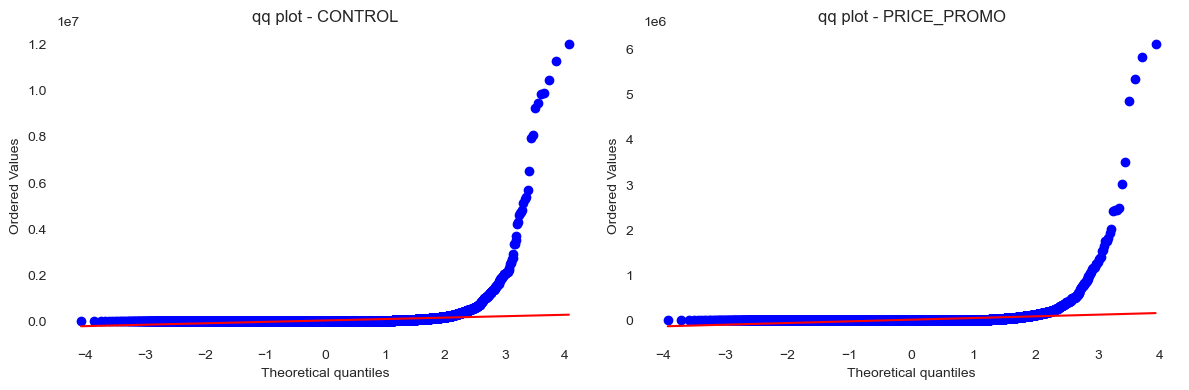

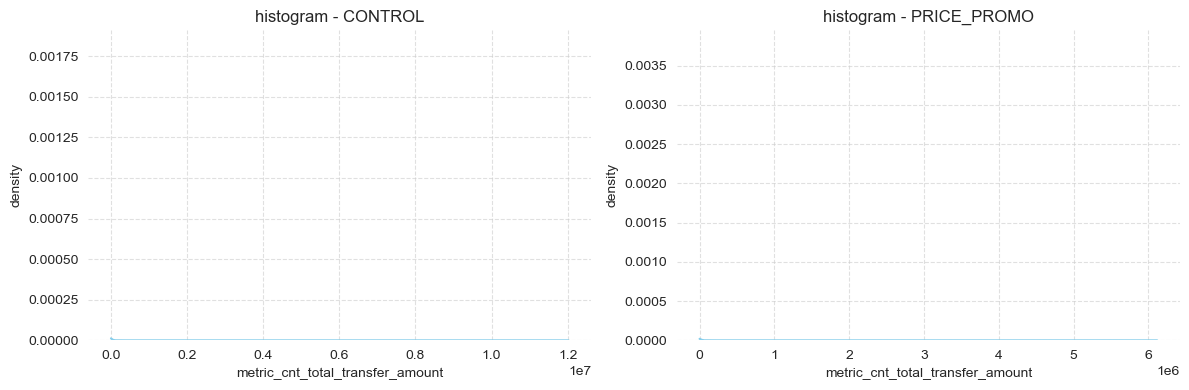

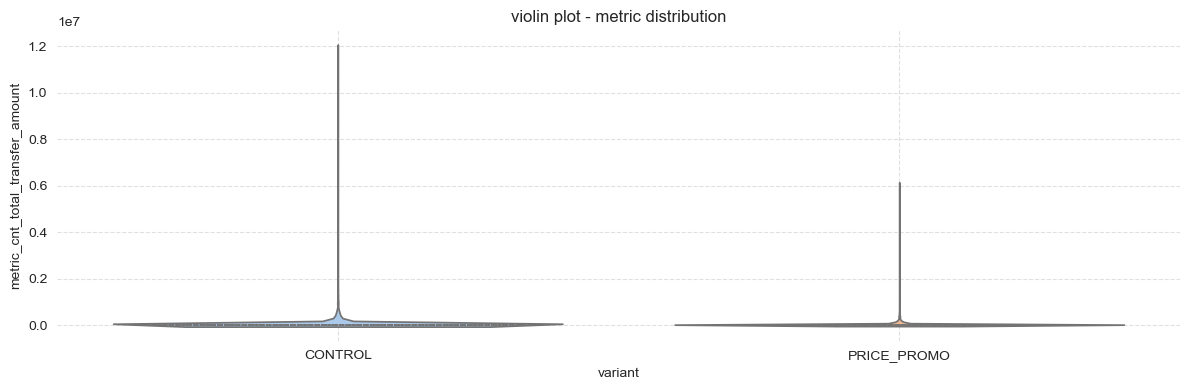

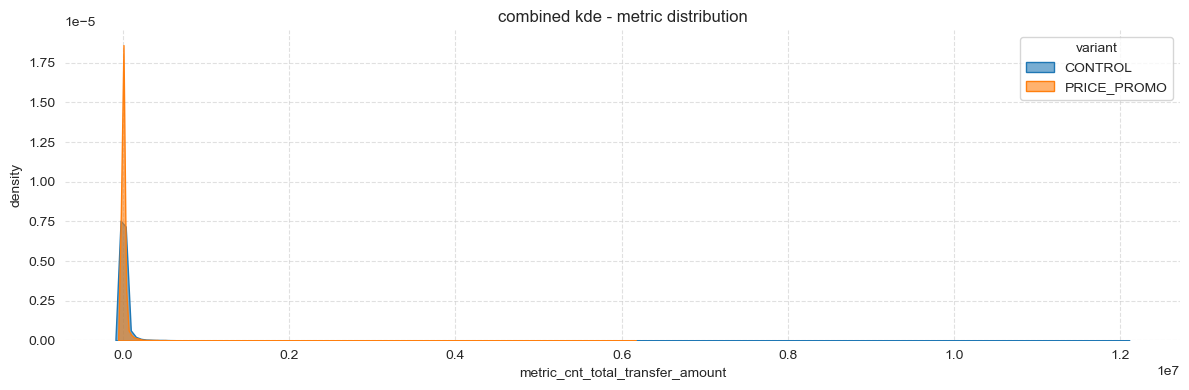

------------------------------------------------------------------------- NORMAL DISTRIBUTION TEST RESULTS -------------------------------------------------------------------------
variant CONTROL: normaltest statistic = 77289.8714, p-value = 0.0000
variant PRICE_PROMO: normaltest statistic = 40890.9570, p-value = 0.0000

USE NORMAL DISTRIBUTION TESTS: False


In [55]:
print_title('NORMAL DISTRIBUTION VISUAL ANALYSIS', 180)
plot_qq(selected_df, variant_column, metric_column)
plot_histogram_kde(selected_df, variant_column, metric_column)
plot_violin(selected_df, variant_column, metric_column)
plot_combined_kde(selected_df, variant_column, metric_column)

print_title('NORMAL DISTRIBUTION TEST RESULTS', 180)
distribution_results = calculate_distribution(selected_df, variant_column, metric_column)

is_normal_distribution = set_normal_distribution_flag(distribution_results, alpha=0.05)
print(f'\nUSE NORMAL DISTRIBUTION TESTS: {is_normal_distribution}')

### SAMPLE VARIANCES

In [56]:
def calculate_variance_analysis(selected_df, variant_column, metric_column, alpha=0.05):
    # Levene's test for homogeneity of variances
    variants = selected_df[variant_column].unique()
    groups = [selected_df.loc[selected_df[variant_column] == variant, metric_column] for variant in variants]
    stat, p_value = stats.levene(*groups, center='median')
    is_equal_variance = p_value > alpha
    print(f"Levene test statistic = {stat:.4f}, p_value = {p_value:.4f}")
    print(f"Equal variance assumption: {is_equal_variance}")
    return {'test': 'levene', 'stat': stat, 'p_value': p_value, 'is_equal_variance': is_equal_variance}

def set_equal_variance_flag(variance_results, alpha=0.05):
    # Set flag for equal variance based on p_value > alpha
    is_equal_variance = variance_results['p_value'] > alpha
    return is_equal_variance

In [57]:
print_title('VARIANCE TEST RESULTS', 180)
variance_results = calculate_variance_analysis(selected_df, variant_column, metric_column)

is_equal_variance = set_equal_variance_flag(variance_results, alpha=0.05)
print(f'\nUSE EQUAL VARIANCE TESTS: {is_equal_variance}')

------------------------------------------------------------------------------ VARIANCE TEST RESULTS ------------------------------------------------------------------------------
Levene test statistic = 27.2777, p_value = 0.0000
Equal variance assumption: False

USE EQUAL VARIANCE TESTS: False


## STATISTICAL TESTING

### TEST AND TECHNICHES SELECTION

In [58]:
def configure_ab_test(metric_type, is_equal_variance, is_normal_distribution, num_variants, variant_ratio, sample_sizes, is_strong_outlier_effect, size_threshold = 30):
    print(f'metric_type: {metric_type}')
    print(f'is_normal_distribution: {is_normal_distribution}')
    print(f'is_equal_variance: {is_equal_variance}')
    print(f'num_variants: {num_variants}')
    print(f'sample_sizes: {sample_sizes}')
    print(f'variant_ratio: {np.round(variant_ratio, 2)}')
    print(f'is_strong_outlier_effect: {is_strong_outlier_effect}')
    
    ab_test_config = {
        # Bi variant tests
        "use_mann_whitney_u_test": False, # continuous, not normal, works with unbalanced samples
        "use_welchs_t_test": False, # continuous, normal, different variances, works with unbalanced samples (if low unbalance applied although same variants)
        "use_t_test": False, # continuous, normal, equal variances, not recommended if unbalanced
        "use_fisher_exact_test": False, # proportions, small sample size, works with unbalanced samples, # for proportions, only size matters due to central limit theorem
        "use_two_proportion_z_test": False, # proportions, large sample size, works with unbalanced samples, used alone or post Pearson Chi-square with Bonferroni for multiple variants, # for proportions, only size matters due to central limit theorem
        ## Multiple variants tests
        "use_anova_test": False, # continuous, normal, not recommended if unbalanced, equal variance
        "use_welch_anova_test": False, # continuous, normal, if unbalanced, different variance
        "use_kruskal_wallis_test": False, # continuous, not normal, works with unbalanced samples
        "use_pearson_chi_square_test": False, # proportions, works with unbalanced samples but needs correction
        ## Multiple variants post-pairs tests
        "use_tukey_hsd_test": False, # post anova, continuous, not recommended if unbalanced
        "use_games_howell_test": False, # post anova, continuous, for unbalanced samples
        "use_dunn_test": False, # post kruskal wallis, continuous, needs bonferroni, works with unbalanced samples
        ## Multiple variants correction
        "use_bonferroni_correction": False, # if more than 2 variants and tukey pr games howell is not used
        ## Unbalance data: N = A/B, if N < 2.5 use normal testing, if N < 5x use balance resampling, if N > 5x use bootstraping
        "use_balance_resampling": False, # for unbalanced sample sizes, equalizing groups, downsampling,
        "use_bootstraping": False, # for small sample sizes or unbalanced groups, estimating confidence intervals, upsampling,
        ## Additional techniques
        "use_bayesian_test": False, # for probabilistic interpretation, alternative to p-values, small samples
        "use_permutation_test": False # for distribution-free significance testing, alternative to t-tests or z-tests, extrange distributions
    }
    
    # Unbalance techniques
    if variant_ratio >= 2.5 and variant_ratio < 5:
        ab_test_config["use_balance_resampling"] = True
    elif variant_ratio >= 5:
        ab_test_config["use_bootstraping"] = True

    if metric_type == 'continuous':
        # Bi variant tests
        if num_variants == 2:
            if not is_normal_distribution:
                ab_test_config["use_mann_whitney_u_test"] = True
            else:
                if is_equal_variance:
                    if variant_ratio < 1.5:
                        ab_test_config["use_t_test"] = True 
                    elif 1.5 <= variant_ratio <= 2.5:
                        ab_test_config["use_welchs_t_test"] = True 
                    else:  
                        ab_test_config["use_t_test"] = True
                else:
                    ab_test_config["use_welchs_t_test"] = True 
        # Multiple variant tests
        elif num_variants > 2:
            if is_normal_distribution:
                if is_equal_variance:
                    if variant_ratio < 1.5:
                        ab_test_config["use_anova_test"] = True
                        ab_test_config["use_tukey_hsd_test"] = True
                    elif 1.5 <= variant_ratio <= 2.5:
                        ab_test_config["use_welch_anova_test"] = True
                        ab_test_config["use_games_howell_test"] = True
                    else:  # variant_ratio > 2.5
                        ab_test_config["use_anova_test"] = True
                        ab_test_config["use_tukey_hsd_test"] = True 
                else:
                    ab_test_config["use_welch_anova_test"] = True
                    ab_test_config["use_games_howell_test"] = True  
            else:
                ab_test_config["use_kruskal_wallis_test"] = True
                ab_test_config["use_dunn_test"] = True
            
            if not (ab_test_config["use_tukey_hsd_test"] or 
                    ab_test_config["use_games_howell_test"]) or ab_test_config["use_dunn_test"]:
                ab_test_config["use_bonferroni_correction"] = True

    # Proportions metric
    elif metric_type == 'proportion':
        # Bi variant tests
        if num_variants == 2:
            if sample_sizes.min() < size_threshold:
                ab_test_config["use_fisher_exact_test"] = True
            else:
                ab_test_config["use_two_proportion_z_test"] = True
        # Multiple variant tests
        elif num_variants > 2:
            ab_test_config["use_pearson_chi_square_test"] = True
            ab_test_config["use_two_proportion_z_test"] = True
            ab_test_config["use_bonferroni_correction"] = True

    # Additional techniques for small sample sizes (threshold < size_threshold)
    if sample_sizes.min() < 1000 or not is_normal_distribution:
        ab_test_config["use_bayesian_test"] = True
        
    if sample_sizes.min() < 100 or (is_strong_outlier_effect and sample_sizes.min() < 2000):
        ab_test_config["use_permutation_test"] = True
    return ab_test_config

In [59]:
print_title('TEST VARIABLES', 60)
ab_test_config = configure_ab_test(metric_type, is_equal_variance, is_normal_distribution, num_variants, variant_ratio, sample_sizes, is_strong_outlier_effect)
print('\n')
print_title('TEST SELECTION', 60)
print({key: value for key, value in ab_test_config.items() if value})

---------------------- TEST VARIABLES ----------------------
metric_type: continuous
is_normal_distribution: False
is_equal_variance: False
num_variants: 2
sample_sizes: VARIANT
CONTROL        29450
PRICE_PROMO    16166
Name: count, dtype: int64
variant_ratio: 1.82
is_strong_outlier_effect: True


---------------------- TEST SELECTION ----------------------
{'use_mann_whitney_u_test': True, 'use_bayesian_test': True}


### UNBALANCE DATA

### TESTS

In [60]:
import itertools

def run_t_test(df, variant_column, metric_column):
    variants = df[variant_column].unique()
    groupA = df[df[variant_column] == variants[0]][metric_column]
    groupB = df[df[variant_column] == variants[1]][metric_column]
    stat, p_value = ttest_ind(groupA, groupB, equal_var=True)
    return {"stat": stat, "p_value": p_value}

def run_welchs_t_test(df, variant_column, metric_column):
    variants = df[variant_column].unique()
    groupA = df[df[variant_column] == variants[0]][metric_column]
    groupB = df[df[variant_column] == variants[1]][metric_column]
    stat, p_value = ttest_ind(groupA, groupB, equal_var=False)
    return {"stat": stat, "p_value": p_value}

def run_mann_whitney(df, variant_column, metric_column):
    variants = df[variant_column].unique()
    groupA = df[df[variant_column] == variants[0]][metric_column]
    groupB = df[df[variant_column] == variants[1]][metric_column]
    stat, p_value = mannwhitneyu(groupA, groupB, alternative='two-sided')
    return {"stat": stat, "p_value": p_value}

def run_two_proportion_z_test(df, variant_column, metric_column):
    agg = df.groupby(variant_column)[metric_column].agg(['sum', 'count']).reset_index()
    agg = agg.rename(columns={'sum': 'success_count', 'count': 'total_count'})
    
    results = []
    # iterate over all unique pairs of variants
    for group1, group2 in itertools.combinations(agg[variant_column].unique(), 2):
        row1 = agg.loc[agg[variant_column] == group1].iloc[0]
        row2 = agg.loc[agg[variant_column] == group2].iloc[0]
        
        success_counts = np.array([row1['success_count'], row2['success_count']])
        total_counts = np.array([row1['total_count'], row2['total_count']])
        
        stat, p_value = proportions_ztest(success_counts, total_counts)
        # compute difference in proportions
        prop1 = row1['success_count'] / row1['total_count']
        prop2 = row2['success_count'] / row2['total_count']
        diff = prop1 - prop2
        
        results.append({
            'group1': group1,
            'group2': group2,
            'diff': diff,
            'p_value': p_value,
            'ci_lower': np.nan,
            'ci_upper': np.nan
        })
    
    return pd.DataFrame(results)

def run_fisher_exact_test(df, variant_column, metric_column):
    contingency_table = pd.crosstab(df[variant_column], df[metric_column])
    stat, p_value = fisher_exact(contingency_table)
    return {"stat": stat, "p_value": p_value}

def run_anova(df, variant_column, metric_column):
    groups = [df[df[variant_column] == variant][metric_column] for variant in df[variant_column].unique()]
    stat, p_value = f_oneway(*groups)
    return {"stat": stat, "p_value": p_value}

def run_welch_anova(df, variant_column, metric_column):
    res = pg.welch_anova(dv=metric_column, between=variant_column, data=df)
    f_stat = res["F"].iloc[0]
    p_value = res["p-unc"].iloc[0]
    return {"stat": f_stat, "p_value": p_value}

def run_kruskal_wallis(df, variant_column, metric_column):
    groups = [df[df[variant_column] == variant][metric_column] for variant in df[variant_column].unique()]
    stat, p_value = kruskal(*groups)
    return {"stat": stat, "p_value": p_value}

def run_chi_square(df, variant_column, metric_column):
    contingency_table = pd.crosstab(df[variant_column], df[metric_column])
    stat, p_value, _, _ = chi2_contingency(contingency_table)
    return {"stat": stat, "p_value": p_value}

def run_tukey_hsd(df, variant_column, metric_column):
    tukey = pairwise_tukeyhsd(endog=df[metric_column], groups=df[variant_column], alpha=0.05)
    table_data = tukey._results_table.data
    header = table_data[0]
    data_rows = table_data[1:]
    df_tukey = pd.DataFrame(data_rows, columns=header)
    df_tukey = df_tukey.rename(columns={
        'group1': 'group1',
        'group2': 'group2',
        'meandiff': 'diff',
        'p-adj': 'p_value',
        'lower': 'ci_lower',
        'upper': 'ci_upper'
    })
    return df_tukey[['group1', 'group2', 'diff', 'p_value', 'ci_lower', 'ci_upper']]

def run_games_howell(df, variant_column, metric_column):
    res = pg.pairwise_gameshowell(data=df, dv=metric_column, between=variant_column)
    res_standard = res.rename(columns={'A': 'group1', 'B': 'group2', 'diff': 'diff', 'pval': 'p_value'})
    res_standard['ci_lower'] = np.nan
    res_standard['ci_upper'] = np.nan
    return res_standard[['group1', 'group2', 'diff', 'p_value', 'ci_lower', 'ci_upper']]

def run_dunn_test(df, variant_column, metric_column):
    res = sp.posthoc_dunn(df, val_col=metric_column, group_col=variant_column, p_adjust='bonferroni')
    tidy_rows = []
    groups = res.index.tolist()
    for i, g1 in enumerate(groups):
        for j, g2 in enumerate(groups):
            if j > i:
                tidy_rows.append({'group1': g1, 'group2': g2, 'p_value': res.loc[g1, g2]})
    df_tidy = pd.DataFrame(tidy_rows)
    df_tidy['diff'] = np.nan
    df_tidy['ci_lower'] = np.nan
    df_tidy['ci_upper'] = np.nan
    return df_tidy[['group1', 'group2', 'diff', 'p_value', 'ci_lower', 'ci_upper']]

def apply_bonferroni_correction(tidy_df):
    p_values = pd.to_numeric(tidy_df['p_value'], errors='coerce').values
    mask = ~np.isnan(p_values)
    adjusted_p_values = multipletests(p_values[mask], method='bonferroni')[1]
    new_p_values = p_values.copy()
    new_p_values[mask] = adjusted_p_values
    tidy_df = tidy_df.copy()
    tidy_df['p_value'] = new_p_values
    return tidy_df

In [61]:
def run_ab_tests(test_config, df, variant_column, metric_column):
    results = {}

    # Continuous
    if test_config.get("use_t_test", False):
        results["t_test"] = run_t_test(df, variant_column, metric_column)
    if test_config.get("use_welchs_t_test", False):
        results["welchs_t_test"] = run_welchs_t_test(df, variant_column, metric_column)
    if test_config.get("use_mann_whitney_u_test", False):
        results["mann_whitney_u_test"] = run_mann_whitney(df, variant_column, metric_column)

    # Proportions
    if test_config.get("use_fisher_exact_test", False):
        results["fisher_exact_test"] = run_fisher_exact_test(df, variant_column, metric_column)
    if test_config.get("use_two_proportion_z_test", False):
        results["two_proportion_z_test"] = run_two_proportion_z_test(df, variant_column, metric_column)

    # Continuous - Multiple Variants
    if test_config.get("use_anova_test", False):
        results["anova_test"] = run_anova(df, variant_column, metric_column)
    if test_config.get("use_welch_anova_test", False):
        results["welch_anova_test"] = run_welch_anova(df, variant_column, metric_column)
    if test_config.get("use_kruskal_wallis_test", False):
        results["kruskal_wallis_test"] = run_kruskal_wallis(df, variant_column, metric_column)

    # Proportions - Multiple Variants
    if test_config.get("use_pearson_chi_square_test", False):
        results["pearson_chi_square_test"] = run_chi_square(df, variant_column, metric_column)

    return results

def run_post_hoc_tests(test_config, df, variant_column, metric_column):
    results = {}

    if test_config.get("use_tukey_hsd_test", False):
        results["tukey_hsd_test"] = run_tukey_hsd(df, variant_column, metric_column)
        
    if test_config.get("use_games_howell_test", False):
        results["games_howell_test"] = run_games_howell(df, variant_column, metric_column)

    if test_config.get("use_dunn_test", False):
        dunn_results = run_dunn_test(df, variant_column, metric_column)
        results["dunn_test"] = dunn_results
        if test_config.get("use_bonferroni_correction", False):
            results["bonferroni_correction"] = apply_bonferroni_correction(dunn_results)

    if test_config.get("use_pearson_chi_square_test", False):
        z_test_results = run_two_proportion_z_test(df, variant_column, metric_column)
        results["two_proportion_z_test"] = z_test_results
        if test_config.get("use_bonferroni_correction", False):
            results["bonferroni_correction"] = apply_bonferroni_correction(z_test_results)

    return results

In [62]:
#ab_test_config['use_pearson_chi_square_test'] = True
#ab_test_config['use_two_proportion_z_test'] = False

ab_test_config

{'use_mann_whitney_u_test': True,
 'use_welchs_t_test': False,
 'use_t_test': False,
 'use_fisher_exact_test': False,
 'use_two_proportion_z_test': False,
 'use_anova_test': False,
 'use_welch_anova_test': False,
 'use_kruskal_wallis_test': False,
 'use_pearson_chi_square_test': False,
 'use_tukey_hsd_test': False,
 'use_games_howell_test': False,
 'use_dunn_test': False,
 'use_bonferroni_correction': False,
 'use_balance_resampling': False,
 'use_bootstraping': False,
 'use_bayesian_test': True,
 'use_permutation_test': False}

In [68]:
def extract_p_value(json_data):
    first_key = next(iter(json_data))
    p_value = json_data[first_key].get("p_value")
    return p_value

def run_complete_ab_test(ab_test_config, selected_df, variant_column, metric_column, num_variants, alpha=0.05):
    ab_test_results = run_ab_tests(ab_test_config, selected_df, variant_column, metric_column)
    if num_variants > 2:
        p_value = extract_p_value(ab_test_results)
        if p_value is not None and p_value < alpha:
            post_hoc_results = run_post_hoc_tests(ab_test_config, selected_df, variant_column, metric_column)
            ab_test_results["post_hoc"] = post_hoc_results
    standardized_results = {}
    if "post_hoc" in ab_test_results and ab_test_results["post_hoc"]:
        standardized_results["post_hoc"] = {}
        for test_name, test_data in ab_test_results["post_hoc"].items():
            if hasattr(test_data, "to_dict"):
                comparisons = test_data.to_dict("records")
            elif isinstance(test_data, list):
                comparisons = test_data
            else:
                comparisons = []
            standardized_results["post_hoc"][test_name] = []
            for comp in comparisons:
                p_val = comp.get("p_value")
                standardized_results["post_hoc"][test_name].append({
                    "group1": comp.get("group1"),
                    "group2": comp.get("group2"),
                    "p_value": p_val,
                    "significant": p_val < alpha if p_val is not None else None
                })
    else:
        primary_test_key = next((k for k in ab_test_results.keys() if k != "post_hoc"), None)
        if primary_test_key is not None:
            primary_test_result = ab_test_results[primary_test_key]
            p_val = primary_test_result.get("p_value")
            group1 = primary_test_result.get("group1")
            group2 = primary_test_result.get("group2")
            if group1 is None or group2 is None:
                groups = selected_df[variant_column].unique()
                if len(groups) >= 2:
                    group1, group2 = groups[0], groups[1]
            standardized_results["overall_test"] = {
                "test": primary_test_key,
                "group1": group1,
                "group2": group2,
                "p_value": p_val,
                "significant": p_val < alpha if p_val is not None else None
            }
    rows = []
    if "overall_test" in standardized_results:
        overall = standardized_results["overall_test"]
        rows.append({
            "test": overall.get("test"),
            "group1": overall.get("group1"),
            "group2": overall.get("group2"),
            "p_value": overall.get("p_value"),
            "significant": overall.get("significant")
        })
    if "post_hoc" in standardized_results:
        for test_name, comparisons in standardized_results["post_hoc"].items():
            for comp in comparisons:
                rows.append({
                    "test": test_name,
                    "group1": comp.get("group1"),
                    "group2": comp.get("group2"),
                    "p_value": comp.get("p_value"),
                    "significant": comp.get("significant")
                })
    df = pd.DataFrame(rows)
    if num_variants > 2:
        allowed_tests = ["bonferroni_correction", "tukey_hsd_test", "games_howell_test"]
        df = df[df["test"].isin(allowed_tests)]
    df = df.drop(columns={"test"})
    return df

In [69]:
standardized_results = run_complete_ab_test(ab_test_config, selected_df, variant_column, metric_column, num_variants, alpha = 0.05)
standardized_results

,group1,group2,p_value,significant
0,CONTROL,PRICE_PROMO,2.924410e-14,True


In [65]:
alpha = 0.05

# uni
ab_test_results = run_ab_tests(ab_test_config, selected_df, variant_column, metric_column)
print(ab_test_results)

# multi
if num_variants > 2:
    p_value = extract_p_value(ab_test_results)
    if p_value is not None and p_value < alpha:
        post_hoc_results = run_post_hoc_tests(ab_test_config, selected_df, variant_column, metric_column)
        ab_test_results["post_hoc"] = post_hoc_results

# complete with results selection and plot

{'mann_whitney_u_test': {'stat': 247181747.0, 'p_value': 2.9244096368421505e-14}}


In [66]:
ab_test_results

{'mann_whitney_u_test': {'stat': 247181747.0,
  'p_value': 2.9244096368421505e-14}}

### ADDITIONAL TECHNIQUES

### SEGMENT ANALYSIS

In [67]:
## Segmentation
use_welchs_t_test_segmentation = False # for comparing two segments (A-New vs. B-New), continuous, normal, can unbalanced
use_mann_whitney_u_test_segmentation = False # for comparing two segments (A-New vs. B-New), continuous, not normal, can unbalanced
use_two_proportion_z_test_segmentation = False # for comparing two segments (A-New vs. B-New), proportions, large sample
use_fisher_exact_test_segmentation = False # for comparing two segments (A-New vs. B-New), proportions, small sample

## Interaction Tests, if discrepancies between segments
use_anova_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, normal
use_welch_anova_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, normal, can unbalanced
use_kruskal_wallis_interaction_test_segmentation = False # to test interaction effect between variant and segment, continuous, not normal
use_logistic_regression_interaction_test_segmentation = False # to test interaction effect for proportions, equivalent to ANOVA for categorical data
# if true, post hoc with tukey, games howell or dunn